# Convert STEAD Data to Seisbench Format

STEAD is a 3 component seimograms (each 1 min long) where the three components are vertial (Z), north-south (N), and east-west (E).

According to Seisbench, sometimes not all components are available. Should check for this when selecting the data.

## Setup

In [ ]:
# this step mounts your Google drive to the current Colab runtime
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%%capture
! pip install seisbench

In [ ]:
try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

In [ ]:
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import h5py
import pandas as pd
import math

In [ ]:
import pandas as pd
import h5py
import numpy as np

In [ ]:
# Move to STEAD folder
%cd /content/gdrive/MyDrive/path_to_STEAD_data

/content/gdrive/.shortcut-targets-by-id/1kkgdA-hKtghS6jCSGo9StdGqoqNNek2i/CSE 547 Project/STEAD Data


## STEAD Data Formatter

Reading the base.py file.

Possbily useful parameters:
* path - path to dataset
* name - dataset name, default is None
* dimesion_order - dimension order, if not specified will be assumed from config file.
* component_order - component order, if not specified will be assumed from config file.
* sampling_rate - not quite sure what this is
* cache - defines how the waveforms are stored in cache. If each trace is in a single array in the hdf5 file (probably like STEAD), then the strategies 'full' and 'trace' is identical
  *  'full' - when a trace is queries, the full block containig the trace is loaded into the cache and stored in memory. Highest memory consumption, but best performance when using large parts of dataset.
  *  'trace' - when a trace is queries, only the trace is loaded and stored in memory. Useful when only a subset of traces is queried but they are queried multiple times.
  *  None - not good for model training.
* chunks - specific particular chunks to load. Not sure what this chunk is referring to.
* missing_components - how to deal with missing components.

Use preload_waveforms to populate the cache.




In [ ]:
# For defining the column names
metadata_dict = {
            "trace_start_time": "trace_start_time",
            "trace_category": "trace_category",
            "trace_name": "trace_name",
            "p_arrival_sample": "trace_p_arrival_sample",
            "p_status": "trace_p_status",
            "p_weight": "trace_p_weight",
            "p_travel_sec": "path_p_travel_sec",
            "s_arrival_sample": "trace_s_arrival_sample",
            "s_status": "trace_s_status",
            "s_weight": "trace_s_weight",
            "s_travel_sec": "path_s_travel_sec",
            "back_azimuth_deg": "path_back_azimuth_deg",
            "snr_db": "trace_snr_db",
            "coda_end_sample": "trace_coda_end_sample",
            "network_code": "station_network_code",
            "receiver_code": "station_code",
            "receiver_type": "trace_channel",
            "receiver_latitude": "station_latitude_deg",
            "receiver_longitude": "station_longitude_deg",
            "receiver_elevation_m": "station_elevation_m",
            "source_id": "source_id",
            "source_origin_time": "source_origin_time",
            "source_origin_uncertainty_sec": "source_origin_uncertainty_sec",
            "source_latitude": "source_latitude_deg",
            "source_longitude": "source_longitude_deg",
            "source_error_sec": "source_error_sec",
            "source_gap_deg": "source_gap_deg",
            "source_horizontal_uncertainty_km": "source_horizontal_uncertainty_km",
            "source_depth_km": "source_depth_km",
            "source_depth_uncertainty_km": "source_depth_uncertainty_km",
            "source_magnitude": "source_magnitude",
            "source_magnitude_type": "source_magnitude_type",
            "source_magnitude_author": "source_magnitude_author",
        }

In [ ]:
# Edited to retain the ratio between earthquake and noise ratio
def STEAD_converter_ratio(path_hdf5, path_csv, writer: sbd.WaveformDataWriter, basepath=None, **kwargs):
  # Copy metadata and rename columns to SeisBench format
  metadata = pd.read_csv(path_csv)
  metadata.rename(columns=metadata_dict, inplace=True)

  # Get the indexes for the noise data and earthquake data
  n = len(metadata)
  noise_idxs = np.where(metadata['trace_category']=='noise')[0]
  eq_idxs = np.array([i for i in range(n) if i not in noise_idxs])

  # Calculate the ratio between earthquake and noise.
  n_noise = len(noise_idxs)
  n_eq = len(eq_idxs)
  ratio = n_noise/n_eq

  # Don't split the data for now...
  # Idea for what to do: We probably need to get the trace names for those in the testing subset.
  n_testval = int(np.round(n * 0.1))

  # Calculate how many noise and eq data should be in the test & val subset
  n_testval_noise = int(n_testval * ratio)
  n_testval_eq = n_testval - n_testval_noise

  # I want to make sure that all are selected in one way or another.
  # round up the ratio, that way the split will be ~80% for train
  # ~10% for validation and ~10% for testing

  # Use np.where to get the indices, then use random choice to select the
  # indces from there. Make sure to not use the original output from
  # random choice!!
  np.random.seed(123)
  # Get the validation set while retaining earthquake to noise ratio
  val_eq_set = eq_idxs[np.random.choice(n_eq, n_testval_eq, replace=False)]
  val_noise_set = noise_idxs[np.random.choice(n_noise, n_testval_noise, replace=False)]
  val_eq_tns = list(metadata.iloc[val_eq_set]['trace_name'])
  val_noise_tns = list(metadata.iloc[val_noise_set]['trace_name'])
  val_tns = val_eq_tns + val_noise_tns
  val_mask = metadata['trace_name'].isin(val_tns)

  # Remove the already selected validation dataset.
  # Update the eq_idxs and noise_idxs to remove the ones already selected
  #train_dev = metadata['trace_name'][~val_mask].values
  eq_idxs = np.array([idx for idx in eq_idxs if idx not in val_eq_set])
  noise_idxs = np.array([idx for idx in noise_idxs if idx not in val_noise_set])

  test_eq_set = eq_idxs[np.random.choice(len(eq_idxs), n_testval_eq, replace=False)]
  test_noise_set = noise_idxs[np.random.choice(len(noise_idxs), n_testval_noise, replace=False)]
  test_eq_tns = list(metadata.iloc[test_eq_set]['trace_name'])
  test_noise_tns = list(metadata.iloc[test_noise_set]['trace_name'])
  test_tns = test_eq_tns + test_noise_tns
  test_mask = metadata['trace_name'].isin(test_tns)

  metadata['split'] = 'train'
  metadata.loc[val_mask, 'split'] = 'dev'
  metadata.loc[test_mask, 'split'] = 'test'

  # Writer data format
  writer.data_format = {
      "dimension_order": "CW",
      "component_order": "ZNE",
      "sampling_rate": 100,
      "measurement": "velocity",
      "unit": "counts",
      "instrument_response": "not restituted",
  }

  writer.set_total(len(metadata))

  # Read the wavefroms and store each in the writer object.
  with h5py.File(path_hdf5) as f:
      gdata = f["data"]
      for _, row in metadata.iterrows():
          row = row.to_dict()
          waveforms = gdata[row["trace_name"]][()]
          waveforms = waveforms.T  # From WC to CW
          waveforms = waveforms[[2, 1, 0]]  # From ENZ to ZNE

          writer.add_trace(row, waveforms)


In [ ]:
"""
STEAD_converter: Function to convert the STEAD data to Seisbench format,
storing results as a WaveformDataWriter object.
"""

def STEAD_converter(path_hdf5, path_csv, writer: sbd.WaveformDataWriter, basepath=None, **kwargs):
  # Copy metadata and rename columns to SeisBench format
  metadata = pd.read_csv(path_csv)
  metadata.rename(columns=metadata_dict, inplace=True)

  # Don't split the data for now...
  # Idea for what to do: We probably need to get the trace names for those in the testing subset.
  n = len(metadata)
  n_val = int(np.round(n * 0.1))
  n_test = n_val

  # For reproducibility
  np.random.seed(123)
  val_set = np.random.choice(n, n_val, replace=False)
  val_tns = list(metadata.iloc[val_set]['trace_name'])
  val_mask = metadata["trace_name"].isin(val_tns)

  #train_dev = [tn for tn in metadata["trace_name"] if tn not in val_mask]
  train_dev = metadata["trace_name"][~val_mask].values

  test_set = np.random.choice(len(train_dev), n_test, replace=False)
  test_tns = np.take(train_dev, test_set)
  test_mask = metadata["trace_name"].isin(test_tns)

  #print(test_mask) this might not be working correctly.... check
  metadata["split"] = "train"
  metadata.loc[val_mask, "split"] = "dev"
  metadata.loc[test_mask, "split"] = "test"

  # Writer data format
  writer.data_format = {
      "dimension_order": "CW",
      "component_order": "ZNE",
      "sampling_rate": 100,
      "measurement": "velocity",
      "unit": "counts",
      "instrument_response": "not restituted",
  }

  writer.set_total(len(metadata))

  # Read the wavefroms and store each in the writer object.
  with h5py.File(path_hdf5) as f:
      gdata = f["data"]
      for _, row in metadata.iterrows():
          row = row.to_dict()
          waveforms = gdata[row["trace_name"]][()]
          waveforms = waveforms.T  # From WC to CW
          waveforms = waveforms[[2, 1, 0]]  # From ENZ to ZNE

          writer.add_trace(row, waveforms)


## Create csv & hdf5 file in Seisbench format from STEAD data

Steps:
1. Create a WaveformDataWriter and pass in a path for the metadata and waveforms that the writer will write to. (Ex: metadata_path='./seisbench_data/metadata.csv', waveforms_path='./seisbench_data/waveforms.hdf5'). To avoid getting errors, name the .csv file metadata.csv and the waveform data waveforms.hdf5. Store them under the same directory.
2. Run the STEAD_converter by passing in the path to the hdf5 file, the csv file, and the writer object from step 1.
3. Run the _finalize() function to create a .csv in Seisbench format.
4. Run the flush_hdf5() function to create a .hdf5 in Seisbench format.
5. Create a WaveformDataset object by passing in the directory path of the Seisbench data format.

In [ ]:
# writer = sbd.WaveformDataWriter(metadata_path='./seisbench_data/full_data/metadata_full.csv',
#                                 waveforms_path='./seisbench_data/full_data/waveforms_full.hdf5')
# writer = sbd.WaveformDataWriter(metadata_path='./seisbench_data/chunk1_wnoise_data/metadata_c1wn.csv',
#                                 waveforms_path='./seisbench_data/chunk1_wnoise_data/waveforms_c1wn.hdf5')
# writer = sbd.WaveformDataWriter(metadata_path='./seisbench_data/full_data_ratio/metadata_fullr.csv',
#                                 waveforms_path='./seisbench_data/full_data_ratio/waveforms_fullr.hdf5')
writer = sbd.WaveformDataWriter(metadata_path='./seisbench_data/full_data2/metadata_full.csv',
                                waveforms_path='./seisbench_data/full_data2/waveforms_full.hdf5')
# writer = sbd.WaveformDataWriter(metadata_path='./seisbench_data/small_data_ratio/metadata_small.csv',
#                                 waveforms_path='./seisbench_data/small_data_ratio/waveforms_small.hdf5')

In [ ]:
# small_data = STEAD_converter('small_subset.hdf5', 'small_subset.csv', writer=writer)
#STEAD_converter('subset.hdf5', 'subset.csv', writer)
STEAD_converter_ratio('subset.hdf5', 'subset.csv', writer)

<ipython-input-6-e5c0343a0e74>:4: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(path_csv)
Traces converted:  99%|█████████▉| 23223/23350 [00:29<00:00, 824.12it/s]

In [ ]:
# Write Seisbench formatted .csv and .hdf5 file
writer._finalize()
writer.flush_hdf5()

## Sanity Check

In [ ]:
test = h5py.File('./seisbench_data/full_data_ratio/waveforms_fullr.hdf5', 'r')

In [ ]:
test_data = test.get('data')

In [ ]:
test_data = test.get('data')
keys = test_data.keys()
print('Hdf5 noise file has', len(keys), 'entries.')

Hdf5 noise file has 25 entries.


In [ ]:
keys

<KeysViewHDF5 ['bucket0', 'bucket1', 'bucket10', 'bucket11', 'bucket12', 'bucket13', 'bucket14', 'bucket15', 'bucket16', 'bucket17', 'bucket18', 'bucket19', 'bucket2', 'bucket20', 'bucket21', 'bucket22', 'bucket23', 'bucket24', 'bucket3', 'bucket4', 'bucket5', 'bucket6', 'bucket7', 'bucket8', 'bucket9']>

In [ ]:
bucket0 = test_data.get('bucket0')

In [ ]:
bucket0

<HDF5 dataset "bucket0": shape (1024, 3, 6000), type "<f4">

## Create WaveformDataset (sanity check)

Using the Seisbench formatted data, check a WaveformDataset can be created and train, val, test sets can be created correctly.

In [ ]:
dset = sbd.WaveformDataset(path='./seisbench_data/large_data3/',
                                 component_order='ZNE',
                                 samling_rate=100,
                                 cache='full', metadata_cache=True)

In [ ]:
train, val, test = dset.train_dev_test()

In [ ]:
train.metadata

,index,station_network_code,station_code,trace_channel,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_p_arrival_sample,trace_p_status,trace_p_weight,...,trace_snr_db,trace_coda_end_sample,trace_start_time,trace_category,trace_name,split,trace_name_original,trace_chunk,trace_sampling_rate_hz,trace_component_order
0,0,AE,113A,HH,32.768299,-113.766701,118.0,NaN,NaN,NaN,...,NaN,NaN,2018-01-15 04:43:30,noise,"bucket0$0,:3,:6000",train,113A.AE_20180115044330_NO,_large,100,ZNE
5,5,AE,113A,HH,32.768299,-113.766701,118.0,NaN,NaN,NaN,...,NaN,NaN,2018-01-15 19:28:18,noise,"bucket0$1,:3,:6000",train,113A.AE_20180115192818_NO,_large,100,ZNE
6,6,AE,113A,HH,32.768299,-113.766701,118.0,NaN,NaN,NaN,...,NaN,NaN,2018-01-16 02:40:18,noise,"bucket0$2,:3,:6000",train,113A.AE_20180116024018_NO,_large,100,ZNE
7,7,AE,113A,HH,32.768299,-113.766701,118.0,NaN,NaN,NaN,...,NaN,NaN,2018-01-16 05:27:36,noise,"bucket0$3,:3,:6000",train,113A.AE_20180116052736_NO,_large,100,ZNE
8,8,AE,113A,HH,32.768299,-113.766701,118.0,NaN,NaN,NaN,...,NaN,NaN,2018-01-16 06:21:30,noise,"bucket0$4,:3,:6000",train,113A.AE_20180116062130_NO,_large,100,ZNE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116742,116742,PB,B087,EH,33.495500,-116.602667,1139.0,796.0,autopicker,0.90,...,[21.29999924 21.10000038 16.39999962],[[1591.]],2011-11-02 08:06:00.420000,earthquake_local,"bucket113$211,:3,:6000",train,B087.PB_20111102080559_EV,_large,100,ZNE
116744,116744,PB,B087,EH,33.495500,-116.602667,1139.0,899.0,autopicker,0.93,...,[23.79999924 24.39999962 23.10000038],[[1517.]],2011-11-02 09:37:29.990000,earthquake_local,"bucket113$212,:3,:6000",train,B087.PB_20111102093728_EV,_large,100,ZNE
116746,116746,PB,B087,EH,33.495500,-116.602667,1139.0,500.0,manual,0.61,...,[12.19999981 11.69999981 13.19999981],[[2382.]],2011-11-02 14:39:39.670000,earthquake_local,"bucket113$213,:3,:6000",train,B087.PB_20111102143938_EV,_large,100,ZNE
116747,116747,PB,B087,EH,33.495500,-116.602667,1139.0,692.0,autopicker,0.83,...,[23.29999924 25. 20.89999962],[[2126.]],2011-11-02 15:32:01.620000,earthquake_local,"bucket113$214,:3,:6000",train,B087.PB_20111102153200_EV,_large,100,ZNE


In [ ]:
val.metadata

,index,station_network_code,station_code,trace_channel,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_p_arrival_sample,trace_p_status,trace_p_weight,...,trace_snr_db,trace_coda_end_sample,trace_start_time,trace_category,trace_name,split,trace_name_original,trace_chunk,trace_sampling_rate_hz,trace_component_order
1,1,AE,113A,HH,32.768299,-113.766701,118.0,NaN,NaN,NaN,...,NaN,NaN,2018-01-15 09:20:00,noise,"bucket6$0,:3,:6000",dev,113A.AE_20180115092000_NO,_large,100,ZNE
2,2,AE,113A,HH,32.768299,-113.766701,118.0,NaN,NaN,NaN,...,NaN,NaN,2018-01-15 09:35:24,noise,"bucket6$1,:3,:6000",dev,113A.AE_20180115093524_NO,_large,100,ZNE
20,20,AE,319A,HH,31.375700,-109.280899,1187.0,NaN,NaN,NaN,...,NaN,NaN,2018-01-15 19:02:24,noise,"bucket6$2,:3,:6000",dev,319A.AE_20180115190224_NO,_large,100,ZNE
25,25,AE,319A,HH,31.375700,-109.280899,1187.0,NaN,NaN,NaN,...,NaN,NaN,2018-01-16 00:07:00,noise,"bucket6$3,:3,:6000",dev,319A.AE_20180116000700_NO,_large,100,ZNE
27,27,AE,319A,HH,31.375700,-109.280899,1187.0,NaN,NaN,NaN,...,NaN,NaN,2018-01-16 00:25:54,noise,"bucket6$4,:3,:6000",dev,319A.AE_20180116002554_NO,_large,100,ZNE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116702,116702,PB,B087,EH,33.495500,-116.602667,1139.0,500.0,manual,0.59,...,[15.19999981 16. 16.10000038],[[3199.]],2011-10-26 08:34:44.200000,earthquake_local,"bucket114$406,:3,:6000",dev,B087.PB_20111026083443_EV,_large,100,ZNE
116709,116709,PB,B087,EH,33.495500,-116.602667,1139.0,1000.0,manual,0.60,...,[44.09999847 43.20000076 41.90000153],[[2738.]],2011-10-27 02:37:34.780000,earthquake_local,"bucket114$407,:3,:6000",dev,B087.PB_20111027023734_EV,_large,100,ZNE
116730,116730,PB,B087,EH,33.495500,-116.602667,1139.0,500.0,manual,0.62,...,[12.89999962 15.5 10.30000019],[[1511.]],2011-10-31 22:18:02.120000,earthquake_local,"bucket114$408,:3,:6000",dev,B087.PB_20111031221801_EV,_large,100,ZNE
116745,116745,PB,B087,EH,33.495500,-116.602667,1139.0,800.0,manual,0.67,...,[21.60000038 22. 21.10000038],[[1583.]],2011-11-02 11:49:46.160000,earthquake_local,"bucket114$409,:3,:6000",dev,B087.PB_20111102114945_EV,_large,100,ZNE


In [ ]:
test.metadata

,index,station_network_code,station_code,trace_channel,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_p_arrival_sample,trace_p_status,trace_p_weight,...,trace_snr_db,trace_coda_end_sample,trace_start_time,trace_category,trace_name,split,trace_name_original,trace_chunk,trace_sampling_rate_hz,trace_component_order
3,3,AE,113A,HH,32.768299,-113.766701,118.0,NaN,NaN,NaN,...,NaN,NaN,2018-01-15 13:21:30,noise,"bucket7$0,:3,:6000",test,113A.AE_20180115132130_NO,_large,100,ZNE
4,4,AE,113A,HH,32.768299,-113.766701,118.0,NaN,NaN,NaN,...,NaN,NaN,2018-01-15 16:17:12,noise,"bucket7$1,:3,:6000",test,113A.AE_20180115161712_NO,_large,100,ZNE
12,12,AE,113A,HH,32.768299,-113.766701,118.0,NaN,NaN,NaN,...,NaN,NaN,2018-01-16 17:58:00,noise,"bucket7$2,:3,:6000",test,113A.AE_20180116175800_NO,_large,100,ZNE
21,21,AE,319A,HH,31.375700,-109.280899,1187.0,NaN,NaN,NaN,...,NaN,NaN,2018-01-15 22:10:00,noise,"bucket7$3,:3,:6000",test,319A.AE_20180115221000_NO,_large,100,ZNE
23,23,AE,319A,HH,31.375700,-109.280899,1187.0,NaN,NaN,NaN,...,NaN,NaN,2018-01-15 23:06:42,noise,"bucket7$4,:3,:6000",test,319A.AE_20180115230642_NO,_large,100,ZNE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116729,116729,PB,B087,EH,33.495500,-116.602667,1139.0,700.0,manual,0.66,...,[26. 28.5 24.20000076],[[1301.]],2011-10-31 15:10:54.870000,earthquake_local,"bucket115$406,:3,:6000",test,B087.PB_20111031151053_EV,_large,100,ZNE
116735,116735,PB,B087,EH,33.495500,-116.602667,1139.0,897.0,autopicker,0.92,...,[23.70000076 21.60000038 21.79999924],[[2230.]],2011-11-01 12:26:46.150000,earthquake_local,"bucket115$407,:3,:6000",test,B087.PB_20111101122645_EV,_large,100,ZNE
116738,116738,PB,B087,EH,33.495500,-116.602667,1139.0,599.0,autopicker,0.94,...,[20.60000038 20.10000038 20.10000038],[[1654.]],2011-11-01 21:17:35.590000,earthquake_local,"bucket115$408,:3,:6000",test,B087.PB_20111101211734_EV,_large,100,ZNE
116741,116741,PB,B087,EH,33.495500,-116.602667,1139.0,699.0,autopicker,0.93,...,[25.10000038 27.10000038 22.20000076],[[1296.]],2011-11-02 07:35:13.270000,earthquake_local,"bucket115$409,:3,:6000",test,B087.PB_20111102073512_EV,_large,100,ZNE


In [ ]:
train.preload_waveforms()
val.preload_waveforms()
#test.preload_waveforms()

In [ ]:
test.preload_waveforms()

In [ ]:
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}

In [ ]:
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(val)
test_generator = sbg.GenericGenerator(test)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, sigma=30, dim=0)
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)
test_generator.add_augmentations(augmentations)

In [ ]:
print('Train length is', len(train_generator))
print('Dev length is', len(dev_generator))
print('Test length is', len(test_generator))

Train length is 93400
Dev length is 11675
Test length is 11675


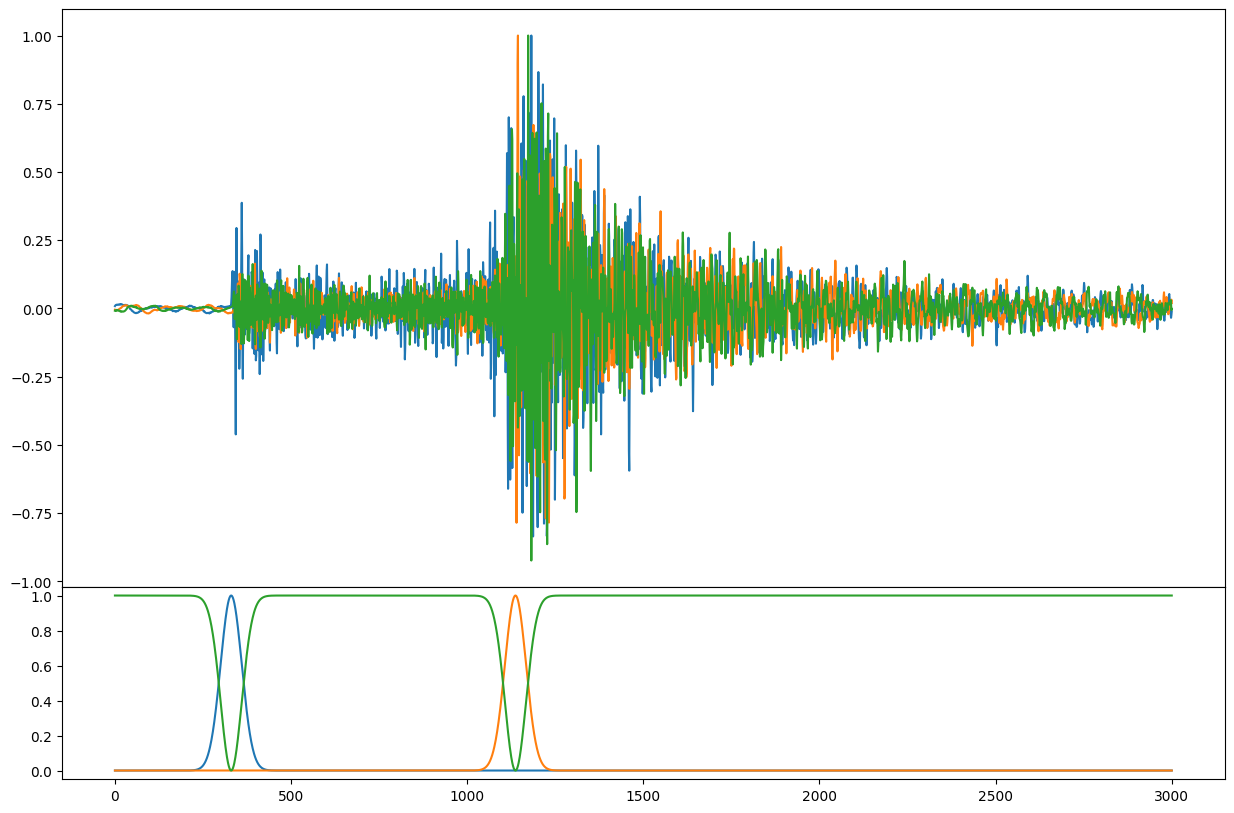

In [ ]:
sample = train_generator[np.random.randint(len(train_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)